In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [1]:
%matplotlib inline

# utilities
from functools import partial
import time
import os

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# network analysis tools
import igraph as ig

# multiprocessing tools
import multiprocessing as mp


# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm

%autosave 15


Autosaving every 15 seconds


In [2]:
random.seed(int(time.time()))
# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/genotypes_full.csv")
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs_expression_avg.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs_genotypes.csv")
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs_expression_avg.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs_genotypes.csv")
# Physical and genetic interactions taken from BioGrid project
full_interactome_df = pd.read_table("./data/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]
genetic_interaction_categories = [
    'additive genetic interaction defined by inequality',
    'suppressive genetic interaction defined by inequality',
    'synthetic genetic interaction defined by inequality'
]
physical_interaction_categories = [
    'association',
    'colocalization',   
    'direct interaction',
    'physical association'
]

In [49]:
def assemble_graph_of_interactions(edges, directed = False, randomize=False):
    interaction_graph = ig.Graph(directed=directed)
    # For some weird reason, igraph can add multiple copies of the same
    # vertex without even signalling about it, therefore the duplicates
    # require manual removal from the dataset 
    vertices = set()
    for source, target in edges:
        vertices |= {source, target}
    vertex_names = list(vertices)
    interaction_graph.add_vertices(vertex_names)
    interaction_graph.add_edges(edges)
    if randomize:
        if directed:
            interaction_graph = interaction_graph.Degree_Sequence(
                interaction_graph.outdegree(),
                interaction_graph.indegree(),
                method='vl'
            )
        else:
            interaction_graph = interaction_graph.Degree_Sequence(
                interaction_graph.degree(),
                method='vl'
            )
    if directed:
        interaction_graph.vs["type"] = \
            [False if deg > 0 else True for deg in interaction_graph.outdegree()] 
    interaction_graph.vs["name"] = vertex_names
    return interaction_graph
    
# Стоит попробовать более совершенные метрики
# подобия, а также добиться лучшей скорости работы
def mean_linkage_similarity(interaction_graph, QTL_graph):
    linked_genes = set([vertex["name"] for vertex in QTL_graph.vs])
    interacting_genes = [vertex["name"] for vertex in interaction_graph.vs]

    mean_coeff = 0.
    # Перебрать все рёбра и сопоставить каждой вершине 
    # пару множеств: eQTLs и pQTLs, которые с ней линкуются,
    # а затем рассмотреть меру пересечения их объединения с мерой пересечения
    if interaction_graph.ecount():
        for edge in interaction_graph.es:
            s_id, t_id = edge.source, edge.target
            s_name = interacting_genes[s_id]
            t_name = interacting_genes[t_id]
            if s_name in linked_genes and t_name in linked_genes:
                ''' 
                    Can subsampling be done faster?
                    And does it matter? 
                '''
                s_neigh = set(QTL_graph.neighbors(s_name, mode="IN"))
                t_neigh = set(QTL_graph.neighbors(t_name, mode="IN"))
                mean_coeff += len(s_neigh & t_neigh) / len(s_neigh | t_neigh)
        mean_coeff /= interaction_graph.ecount()
    return mean_coeff

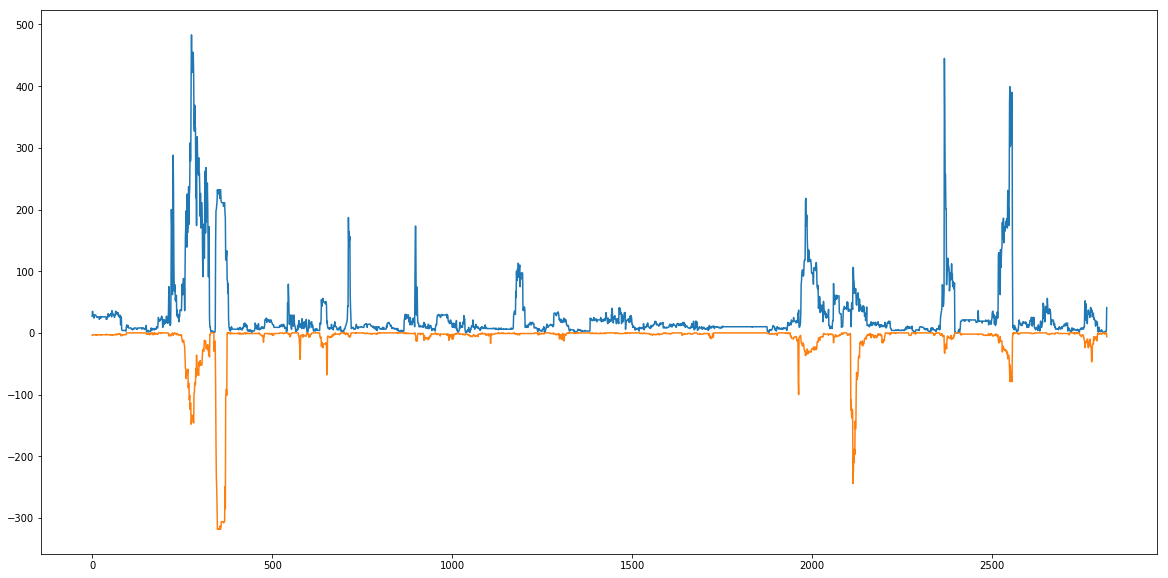

In [50]:
# for q-value threshold in range [1e-8; 1e-3] 
# rebuild graph of interactions and calculate  
# mean value of Jaccard coefficient among graph vertices.

eQTL_df = pd.read_table("./data/eQTLs.csv")
pQTL_df = pd.read_table("./data/pQTLs.csv")

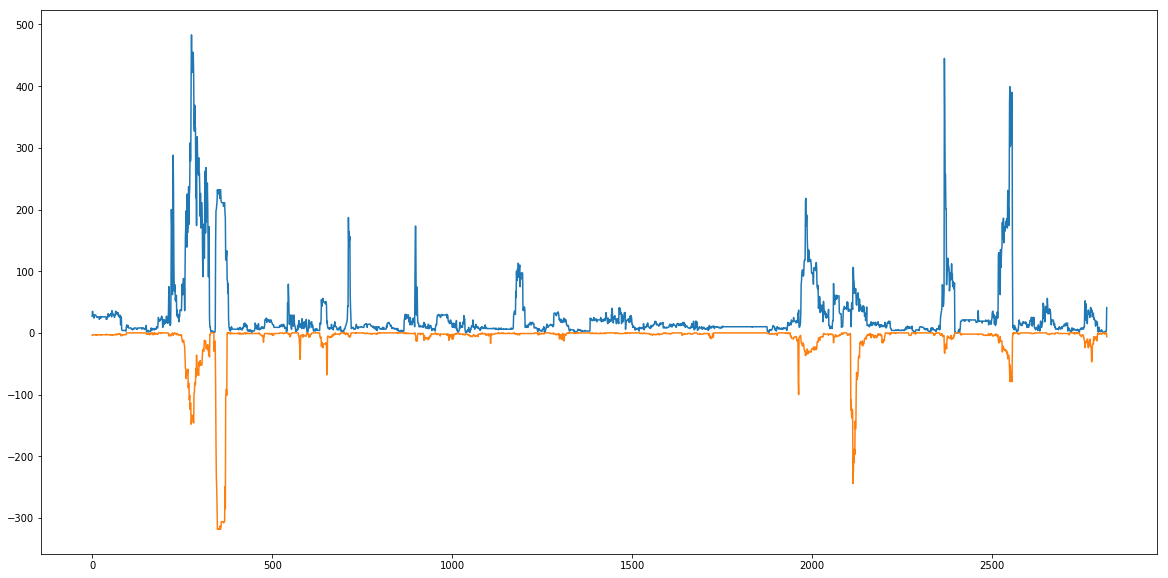

In [121]:
def map_linkages_to_genome_location(QTL_df, full_genotypes_df):
    # It's easier to work with the graphs
    QTL_graph = assemble_graph_of_interactions (
        edges=QTL_df[["SNP", "gene"]].values,
        directed=True
    )
    # Select only the marker vertices
    left_part = QTL_graph.vs.select(type=False)
    # And map them to their absolute genome location 
    marker_to_rownum = \
    dict(
        zip(
            full_genotypes_df.iloc[:, 0],
            np.arange(full_genotypes_df.shape[0])
        )
    )
    # In order to combine plots for different QTLs
    # it's wise to plot them against the total set of markers,
    # disregarding whether linkages for the given marker
    # are calculated or not
    QTL_marker_to_linkages = \
    dict(
        zip(
            full_genotypes_df.iloc[:, 0],
            np.zeros(full_genotypes_df.shape[0])
        )           
    )
    # Add the available linkage data 
    QTL_marker_to_linkages.update(dict(zip(left_part["name"], left_part.outdegree())))
    # Sort the dictionary accordingly to the marker position on the chromosome
    # and unzip it to extract the ordered linkage list
    QTL_x, QTL_y = \
    map(list, 
        zip(
            *sorted(QTL_marker_to_linkages.items(), 
            key=lambda p: marker_to_rownum[p[0]])
        )
    )
    return QTL_x, QTL_y 
    
_, eQTL_y = map_linkages_to_genome_location(eQTL_df, full_genotypes_df)
_, pQTL_y = map_linkages_to_genome_location(pQTL_df, full_genotypes_df)

# TODO: make the axes prettier
plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.plot([-y for y in pQTL_y])
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")
    

In [5]:
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)

genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

In [6]:
# TODO: parallelize threshold processing 
# and run on cluster to achieve sufficient statistical power
# of at least 1000 thresholds
interaction_categories = genetic_interaction_categories + physical_interaction_categories
def analyze_interactions(QTL_df, Q_RANGE, REWIRE_FLAG=False):
    t0 = time.time()
    avg_similarity_by_category = {}
    # TODO: how to add more subcategories in a uniform way?
    for name in ['genetic', 'physical'] + interaction_categories:
        avg_similarity_by_category[name] = []
    interaction_graphs_dict = {}
    for category_name in interaction_categories:
        interacting_genes_df = interactome_df[interactome_df.index == category_name]
        interaction_graphs_dict[category_name] = assemble_graph_of_interactions(
            interacting_genes_df[["Interactor A", "Interactor B"]].values,
            randomize=REWIRE_FLAG
        )
    # TODO: Code duplication
    genetic_interactions_graph = assemble_graph_of_interactions(
        edges=genetic_interactions_df[["Interactor A", "Interactor B"]].values,
        randomize=REWIRE_FLAG
    )
    physical_interactions_graph = assemble_graph_of_interactions(
        edges=physical_interactions_df[["Interactor A", "Interactor B"]].values,
        randomize=REWIRE_FLAG
    )

    for Q_THRESHOLD in Q_RANGE[::-1]:
        # Accordingly to qvalue package in R, all estimated linkages
        # are significant, thereby p- and q-values are interchangeable.
        QTL_df = QTL_df[QTL_df['p.value'] <= Q_THRESHOLD]
        QTL_graph = assemble_graph_of_interactions (
            edges=QTL_df[["SNP", "gene"]].values,
            directed=True
        )
        avg_similarity_by_category['genetic'].append(
            mean_linkage_similarity(genetic_interactions_graph, QTL_graph)
        )
        avg_similarity_by_category['physical'].append(
            mean_linkage_similarity(physical_interactions_graph, QTL_graph)
        )
        for category_name, interaction_graph in interaction_graphs_dict.items():
            avg_similarity_by_category[category_name].append(
                mean_linkage_similarity(interaction_graph, QTL_graph)
            )
                
    print(time.time() - t0)
    return avg_similarity_by_category


In [11]:
def make_plots(avg_sim_by_category, avg_sim_by_category_randomized, type_of_QTLs, Q_RANGE):
   for name in avg_sim_by_category.keys():
        plt.figure(figsize=(20, 10))
        plt.xscale('log')
        plt.plot(Q_RANGE, avg_sim_by_category[name][::-1], label="original")
        plt.plot(Q_RANGE, avg_sim_by_category_randomized[name][::-1], label="randomized")
        plt.title('{} average linkage similarity'.format(type_of_QTLs))
        plt.xlabel(name)
        plt.legend()
        plt.savefig("./img/interactions/" + type_of_QTLs + '_' + name + ".png")
        plt.close()

In [ ]:
Q_RANGE = np.linspace(1e-8, 1e-3, 20)

avg_eQTLs_similarity = analyze_interactions(
    QTL_df=eQTL_df,  
    Q_RANGE=Q_RANGE
)
avg_eQTLs_similarity_for_randomized_interactions = analyze_interactions(
    QTL_df=eQTL_df,  
    Q_RANGE=Q_RANGE,
    REWIRE_FLAG=True
)
avg_pQTLs_similarity = analyze_interactions(
    QTL_df=pQTL_df, 
    Q_RANGE=Q_RANGE
)
avg_pQTLs_similarity_for_randomized_interactions = analyze_interactions(
    QTL_df=pQTL_df,
    Q_RANGE=Q_RANGE,
    REWIRE_FLAG=True
)


In [102]:
make_plots(avg_eQTLs_similarity, avg_eQTLs_similarity_for_randomized_interactions, 'eQTLs', Q_RANGE)
make_plots(avg_pQTLs_similarity, avg_pQTLs_similarity_for_randomized_interactions, 'pQTLs', Q_RANGE)
